In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
# Load training data
nrows_train = 49
nrows_test = 51
X = np.loadtxt('xtrain_challenge.csv', delimiter=',', skiprows = 1)
Y = np.loadtxt('ytrain_challenge.csv', delimiter=',', skiprows = 1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_=scaler.transform(X)

The first step of our work was to try to understand the dataset we had to work on. We had a total of 1,068,504 training observations from which we had to train a model to predict 3,318,296 test observations. Each of the training observations, corresponding to two images, has 37 features and one label: 0 or 1. The label is 1 if the two images correspond to the same person, 0 otherwise. We are thus in the case of supervised learning and more precisely of binary classification.


In [3]:
N=X.shape[0]
ordre=np.arange(0,N)
np.random.shuffle(ordre)

# Use as new variables
X=X[ordre[:]]
Y=Y[ordre[:]]
X_=X_[ordre[:]]

In [4]:
x_train=X[0:100000]
y_train=Y[0:100000]
x_train_scale=X_[0:100000]

x_test=X[100000:200000]
y_test=Y[100000:200000]
x_test_scale=X_[100000:200000]

x_train.shape

(100000, 37)

To get the best accuracy for our predictions, we have to work with good data. Our first reflex was to use a linear transformation to standardize our data (mean=0 and std=1). We applied this to the training and the test set. This avoids that some features are more important than others for no reason.

Once we had our standardized data, the big question was: how are we going to divide our data? Because we have over 1 million observations we knew that if we worked with all of them, the model training would be very long. So we made the choice to shuffle our data and to work with 1/8 of the data at the beginning, at the risk of losing a little bit of accuracy. Once the model has been chosen, we will work with all the data.

We then divided our data into two sets, the training set, and the test set which will allow us to test our models, and above all to check that we haven't overfitted them. The latter is made up of 33% of the data retained.


In [5]:
count=0
for i in range(len(Y)):
    if Y[i]==1:
        count+=1
print("Nombre de données égales à 1 : "+str(count))
print("Nombre de données égales à 0 : "+str(len(Y)-count))
print("Pourcentage des données égales à 0 : "+str((len(Y)-count)*100/len(Y))+"%")

Nombre de données égales à 1 : 39593
Nombre de données égales à 0 : 1028911
Pourcentage des données égales à 0 : 96.29453890673315%


We soon noticed that the classes were very unbalanced. Indeed, among the training observations, more than 96% of the data had the label 0. We thought that we would have to adapt our algorithms to this imbalance because, it could be that our classifier only learns the majority class, and returns the label 0 for each data. First of all, we thought we would do data augmentation, i.e. create new training observations from our training observations with label 0.


In [6]:
# Oversample and plot imbalanced dataset with SMOTE

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

oversample1 = SMOTE(sampling_strategy=0.1)
x_smote, y_smote = oversample1.fit_resample(x_train_scale, y_train)

oversample2 = RandomOverSampler(sampling_strategy=0.1)
x_overs,y_overs=oversample2.fit_resample(x_train_scale, y_train)

under1 = RandomUnderSampler(sampling_strategy=0.5)
x_sample1,y_sample1=under1.fit_resample(x_smote,y_smote)

under2 = RandomUnderSampler(sampling_strategy=0.5)
x_sample2,y_sample2=under2.fit_resample(x_overs,y_overs)

Using TensorFlow backend.


To to resolve the imbalance problem we use the following algorithms:

    The SMOTE algorithm artificially generates instances of the minority class based on the closest neighbors.
    UnderSampling removes some instances of the majority class.
    OverSampling multiplies the instances of the minority class in order to have repetitions.

We test two different ways to increase the number of minority data. The first one is the combination of SMOTE, and UnderSampling. The second is the combination of OverSampling and UnderSampling.


In [7]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(20,15))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores, random_state", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

This function displays the results of a gridsearch.

# Random Forest

### Random Forest with criterion Gini

RandomForest is similar to bagging, but at each node only a limited number of features are studied for the next split. This method is called "features bagging". It prevents the decision trees from being too correlated with each other. Indeed, some features are likely to appear in most of the generated trees. 

In [37]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt')
p_grid_RF = {'n_estimators': [25,50,75,100],'max_depth':[5,10,15,20,25,30]}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
best_estimator_RF=grid_RF.best_params_['n_estimators']
best_depth=grid_RF.best_params_['max_depth']

Best Score: 0.99785
Best params: {'max_depth': 15, 'n_estimators': 50}


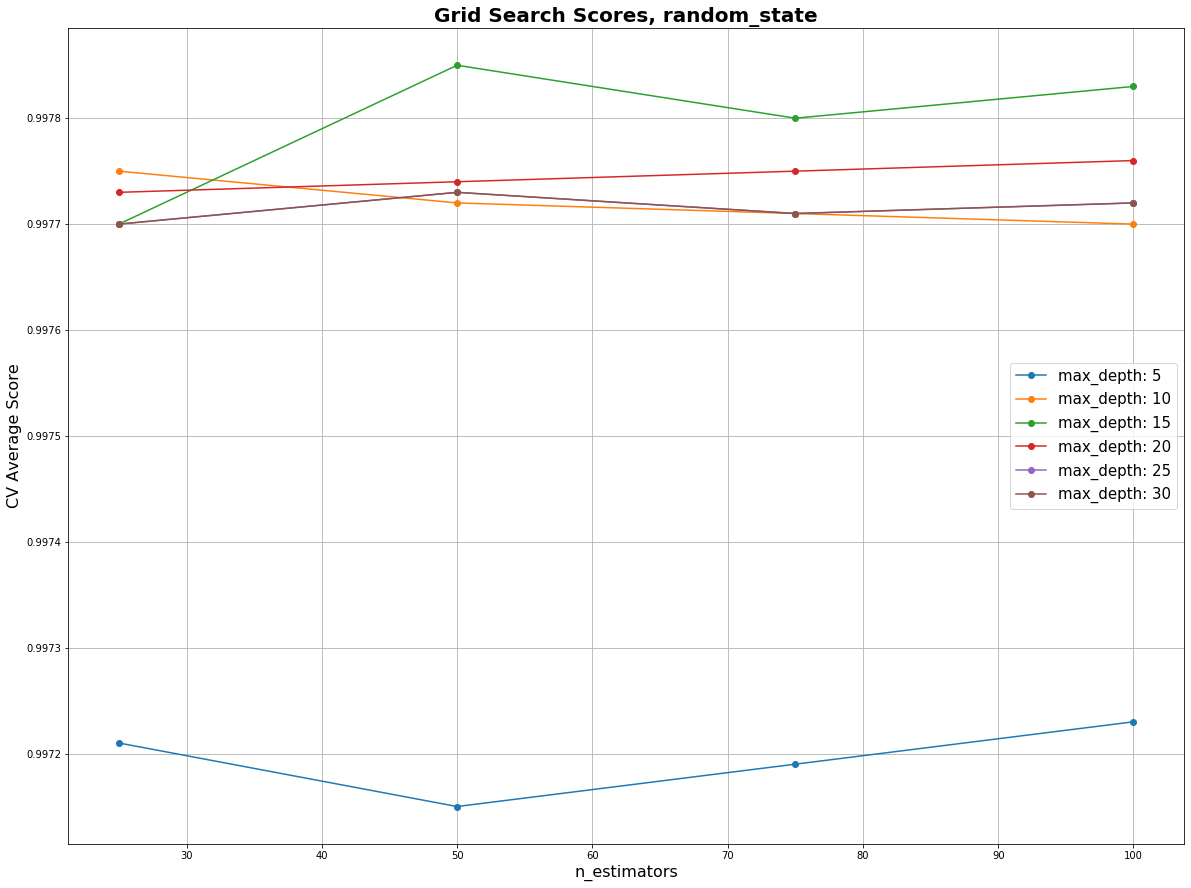

In [42]:
plot_grid_search(grid_RF.cv_results_,  p_grid_RF['n_estimators'],p_grid_RF['max_depth'], 'n_estimators','max_depth')

It seems that you have to choose a tree deep enough (>5), but taking a tree too deep doesn't change much. 
Similarly, choosing too many estimators does not seem to improve our results, and considerably increases the computation time.


Let's test our RandomForest best model on different types of data (scaled or not, balanced or not...)

In [59]:
best_estimator_RF=50
best_depth=15

In [60]:
RF1=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF1.fit(x_train, y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",RF1.score(x_train,y_train))
print("Test score:",RF1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99972
Test score: 0.9981


In [61]:
RF2=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",RF2.score(x_train_scale,y_train))
print("Test score :",RF2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99972
Test score : 0.9981


In [62]:
RF3=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",RF3.score(x_sample1,y_sample1))
print("Test score :",RF3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 0.9997922725384296
Test score : 0.99579


In [63]:
RF4=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",RF4.score(x_sample2,y_sample2))
print("Test score :",RF4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.9999653787564049
Test score : 0.99607


There is some overfitting, indeend the results of the train are a lot higher than those of the validation sample. 
Reducing the depth of the tree would be a good idea to improve the results of RandomForest.

#### Submit a result 

In [26]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',max_depth=15,n_estimators=50)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_RF.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.997954974481

### Random Forest with criterion Entropy

Let's test another criterion to measure the quality of the split.

In [71]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt')
p_grid_RF = {'n_estimators': [25,50,75,100],'max_depth':[5,10,15,20,25,30]}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
best_estimator_RF=grid_RF.best_params_['n_estimators']
best_depth=grid_RF.best_params_['max_depth']

Best Score: 0.9976500000000001
Best params: {'max_depth': 20, 'n_estimators': 75}


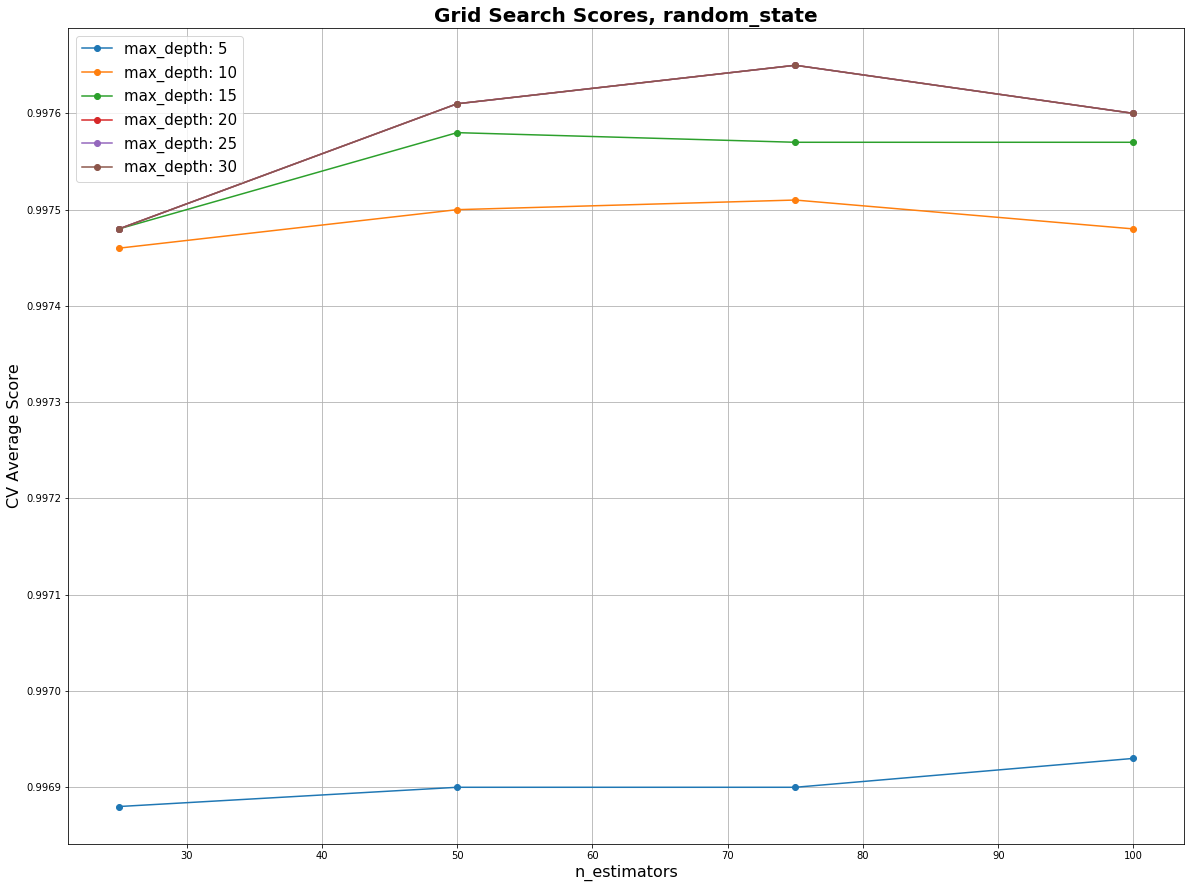

In [77]:
plot_grid_search(grid_RF.cv_results_,  p_grid_RF['n_estimators'],p_grid_RF['max_depth'], 'n_estimators','max_depth')

In [73]:
RF1=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF1.fit(x_train, y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",RF1.score(x_train,y_train))
print("Test score:",RF1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99998
Test score: 0.99814


In [74]:
RF2=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",RF2.score(x_train_scale,y_train))
print("Test score :",RF2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99998
Test score : 0.99814


In [75]:
RF3=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",RF3.score(x_sample1,y_sample1))
print("Test score :",RF3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 1.0
Test score : 0.996


In [76]:
RF4=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=best_depth,n_estimators=best_estimator_RF)
RF4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",RF4.score(x_sample2,y_sample2))
print("Test score :",RF4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.9967


#### Submit a Result

In [ ]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt',max_depth=20,n_estimators=75)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_RF_entropy.csv', ytest, fmt = '%1.0d', delimiter=',')

Score : 0.998002589281

It seems that we get slightly better results with entropy, which we decide to keep for the future.

### The Class Weight criteria

In [18]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="entropy", random_state=26,max_features='sqrt')
p_grid_RF = {'n_estimators': [25,50,75,100],'max_depth':[5,10,15,20,25,30],'class_weight':[{0:1,1:1},{0:1,1:5},{0:1,1:10}]}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
best_estimator_RF=grid_RF.best_params_['n_estimators']
best_depth=grid_RF.best_params_['max_depth']

Best Score: 0.9977199999999999
Best params: {'class_weight': {0: 1, 1: 1}, 'max_depth': 20, 'n_estimators': 100}


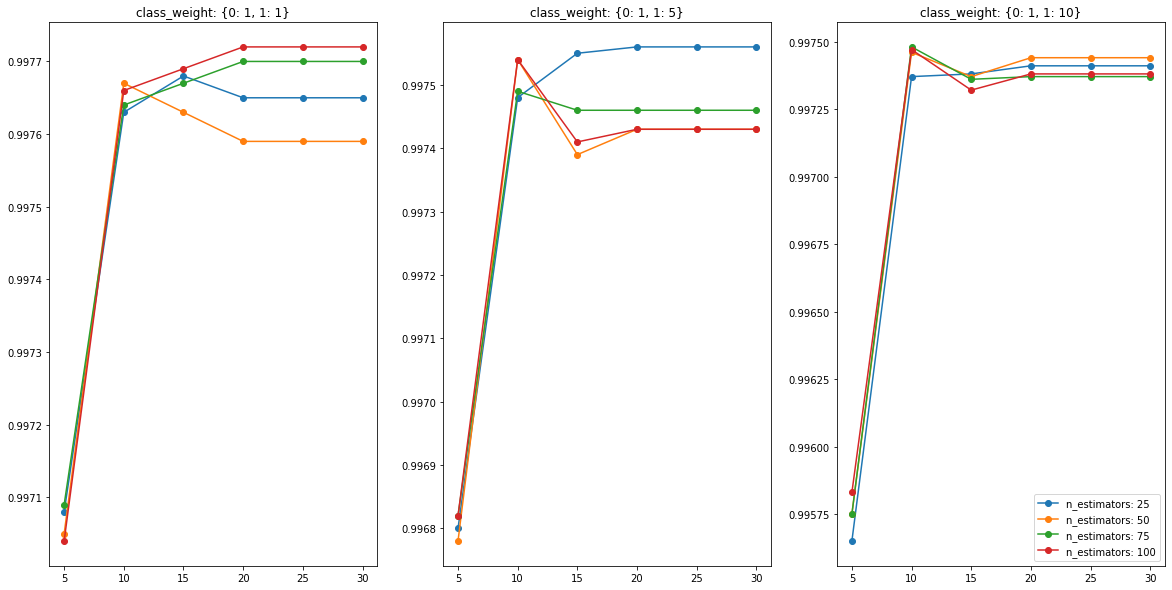

In [39]:
scores1=grid_RF.cv_results_['mean_test_score'][:24].reshape(6,4)
scores2=grid_RF.cv_results_['mean_test_score'][24:48].reshape(6,4)
scores3=grid_RF.cv_results_['mean_test_score'][48:].reshape(6,4)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('class_weight: {0: 1, 1: 1}')
for idx, val in enumerate(p_grid_RF['n_estimators']):
    plt.plot(p_grid_RF['max_depth'], scores1[:,idx], '-o', label= 'n_estimators' + ': ' + str(val))

plt.subplot(132)
plt.title('class_weight: {0: 1, 1: 5}')
for idx, val in enumerate(p_grid_RF['n_estimators']):
    plt.plot(p_grid_RF['max_depth'], scores2[:,idx], '-o', label= 'n_estimators' + ': ' + str(val))

plt.subplot(133)
plt.title('class_weight: {0: 1, 1: 10}')
for idx, val in enumerate(p_grid_RF['n_estimators']):
    plt.plot(p_grid_RF['max_depth'], scores3[:,idx], '-o', label= 'n_estimators' + ': ' + str(val))
    
plt.legend()
plt.show()


The best results are obtein with weight {0: 1, 1: 1}. Trying to balance the data set with this criterion contributes to over-fitting, so we decide to keep the weights {0:1, 1:1}.

# AdaBoost

Adaboost generates a user-specified set of learners (otherwise it will randomly generate a set of weak learners). It will learn the weights of how to add these weak learners to be a strong learner. The weight of each learner is learned based on whether he predicts a sample correctly or not. The weight of a learner which predicts a sample badly is reduced. This process is repeated until the algorithme converges.

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

ada=AdaBoostClassifier()
p_grid_ada = {'n_estimators': [50,100,150,200,250], 'learning_rate':[0.2,0.4,0.6,0.8,1]}   

grid_ada = GridSearchCV(estimator=ada, param_grid=p_grid_ada, scoring="accuracy", cv=5)
grid_ada.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_ada.best_score_))
print("Best params: {}".format(grid_ada.best_params_))
best_estimator_ada=grid_ada.best_params_['n_estimators']
best_lr=grid_ada.best_params_['learning_rate']

Best Score: 0.9978999999999999
Best params: {'learning_rate': 0.4, 'n_estimators': 250}


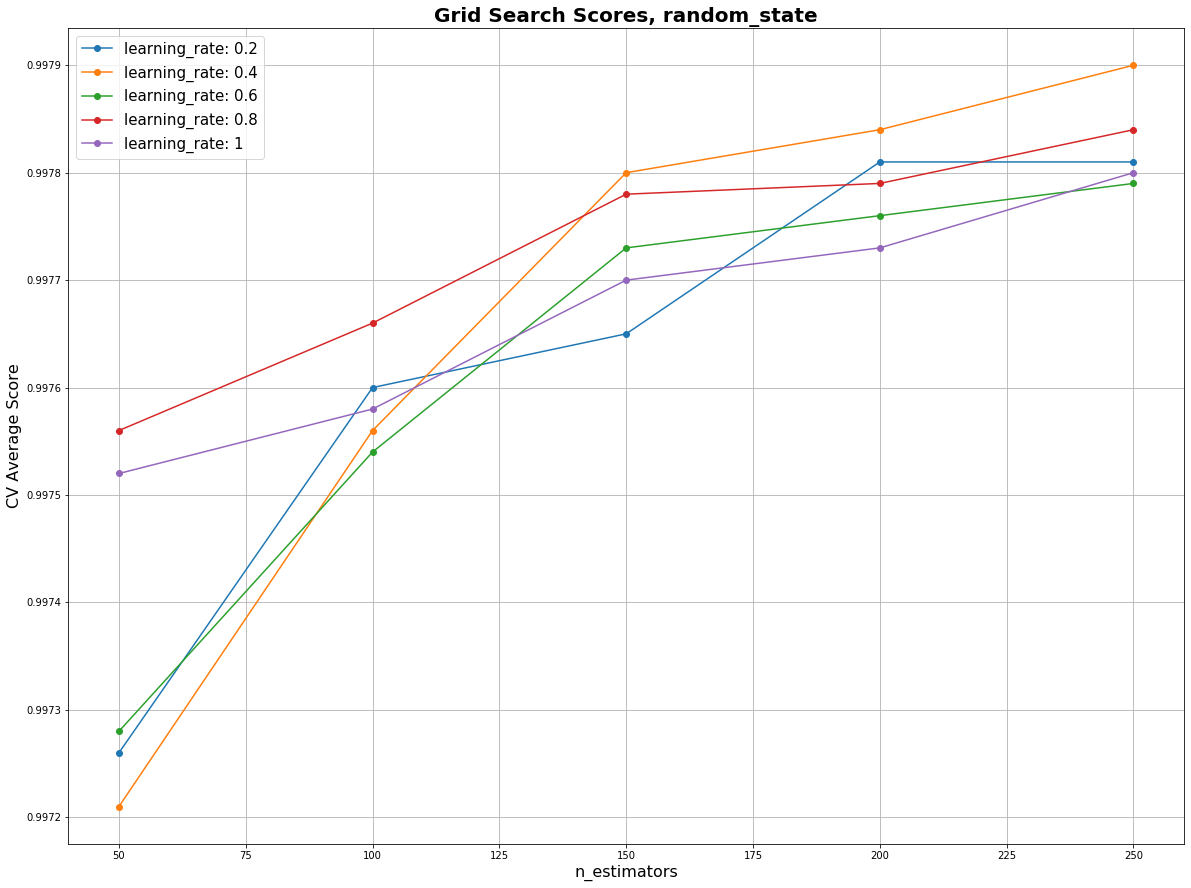

In [44]:
plot_grid_search(grid_ada.cv_results_,  p_grid_ada['n_estimators'],p_grid_ada['learning_rate'], 'n_estimators','learning_rate')

#### Submit a Result 

In [37]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=AdaBoostClassifier(n_estimators=200, learning_rate=0.55)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaBoost2.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.997770542471

The scores clearely increases when the number of estimator increases. The smaller learning rates seems to get better in the ranking when the number of estimators is large.


Let's deepen our research around these values.

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

ada=AdaBoostClassifier()
p_grid_ada2 = {'n_estimators': [175,200,225,250], 'learning_rate':[0.25,0.3,0.35,0.4,0.45,0.5,0.55]}   

grid_ada2 = GridSearchCV(estimator=ada, param_grid=p_grid_ada2, scoring="accuracy", cv=5)
grid_ada2.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_ada2.best_score_))
print("Best params: {}".format(grid_ada2.best_params_))

Best Score: 0.99793
Best params: {'learning_rate': 0.45, 'n_estimators': 250}


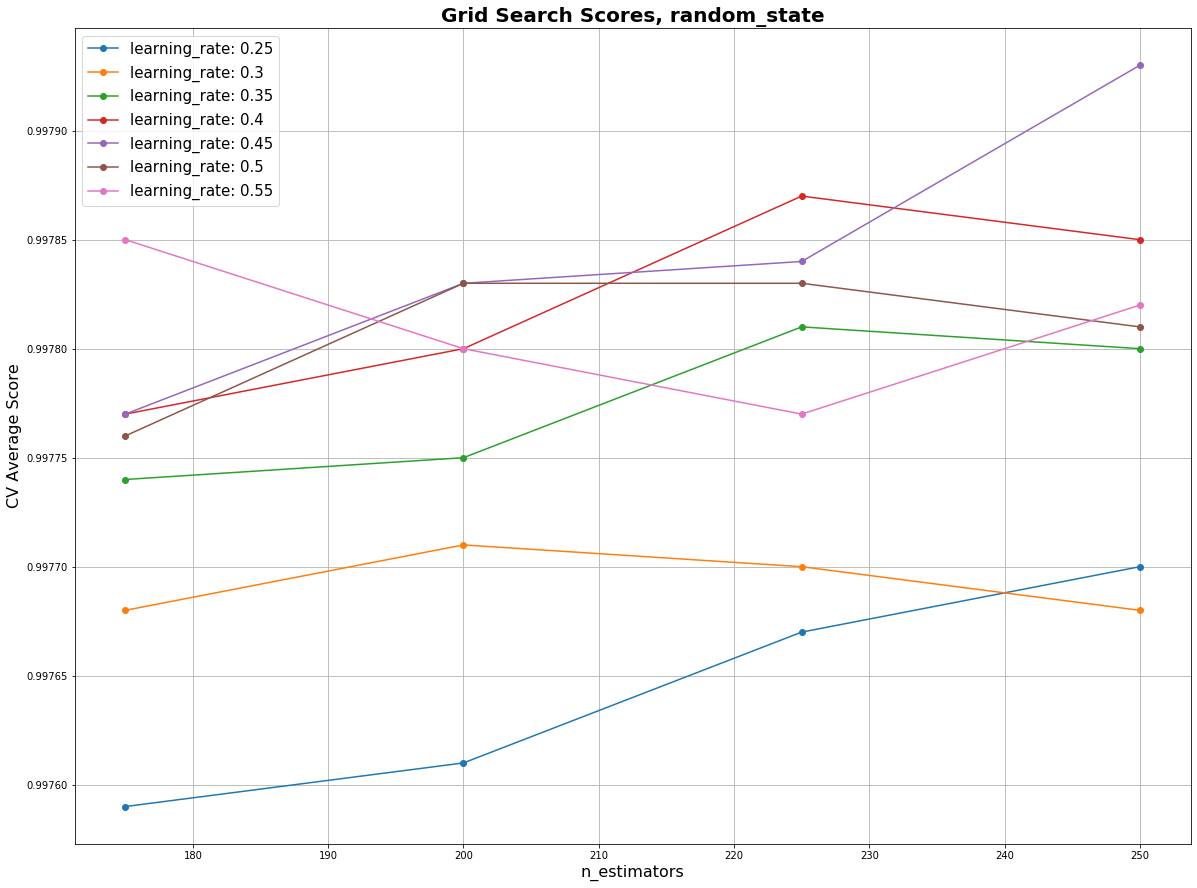

In [31]:
best_estimator_ada=grid_ada2.best_params_['n_estimators']
best_lr=grid_ada2.best_params_['learning_rate']
plot_grid_search(grid_ada2.cv_results_,  p_grid_ada2['n_estimators'],p_grid_ada2['learning_rate'], 'n_estimators','learning_rate')

Let's test our best AdaBoost model on different types of data (scaled or not, balanced or not...)

In [32]:
ada1=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada1.fit(x_train,y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",ada1.score(x_train,y_train))
print("Test score :",ada1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99864
Test score : 0.99797


In [33]:
ada2=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada2.fit(x_train_scale,y_train)
print("Imbalanced Dataset scaled")
print("Training score :",ada2.score(x_train_scale,y_train))
print("Test score :",ada2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99864
Test score : 0.99797


In [34]:
ada3=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada3.fit(x_sample1,y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",ada3.score(x_sample1,y_sample1))
print("Test score :",ada3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 0.9980606060606061
Test score : 0.99618


In [35]:
ada4=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada4.fit(x_sample2,y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",ada4.score(x_sample2,y_sample2))
print("Test score :",ada4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.997991341991342
Test score : 0.99626


#### Submit a Result 

In [36]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaBoost1.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.997780788694

The score increases, but it's a very small increase.

### Look for best hyperparameters

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

ada=AdaBoostClassifier()
p_grid_ada3 = {'n_estimators': [200,225,250], 'learning_rate':[0.4,0.425,0.45,0.475,0.5,0.525,0.55,0.575,0.6]}   

grid_ada3 = GridSearchCV(estimator=ada, param_grid=p_grid_ada3, scoring="accuracy", cv=5)
grid_ada3.fit(x_train_scale, y_train)
print("Best Score: {}".format(grid_ada3.best_score_))
print("Best params: {}".format(grid_ada3.best_params_))

Best Score: 0.9980800000000001
Best params: {'learning_rate': 0.55, 'n_estimators': 200}


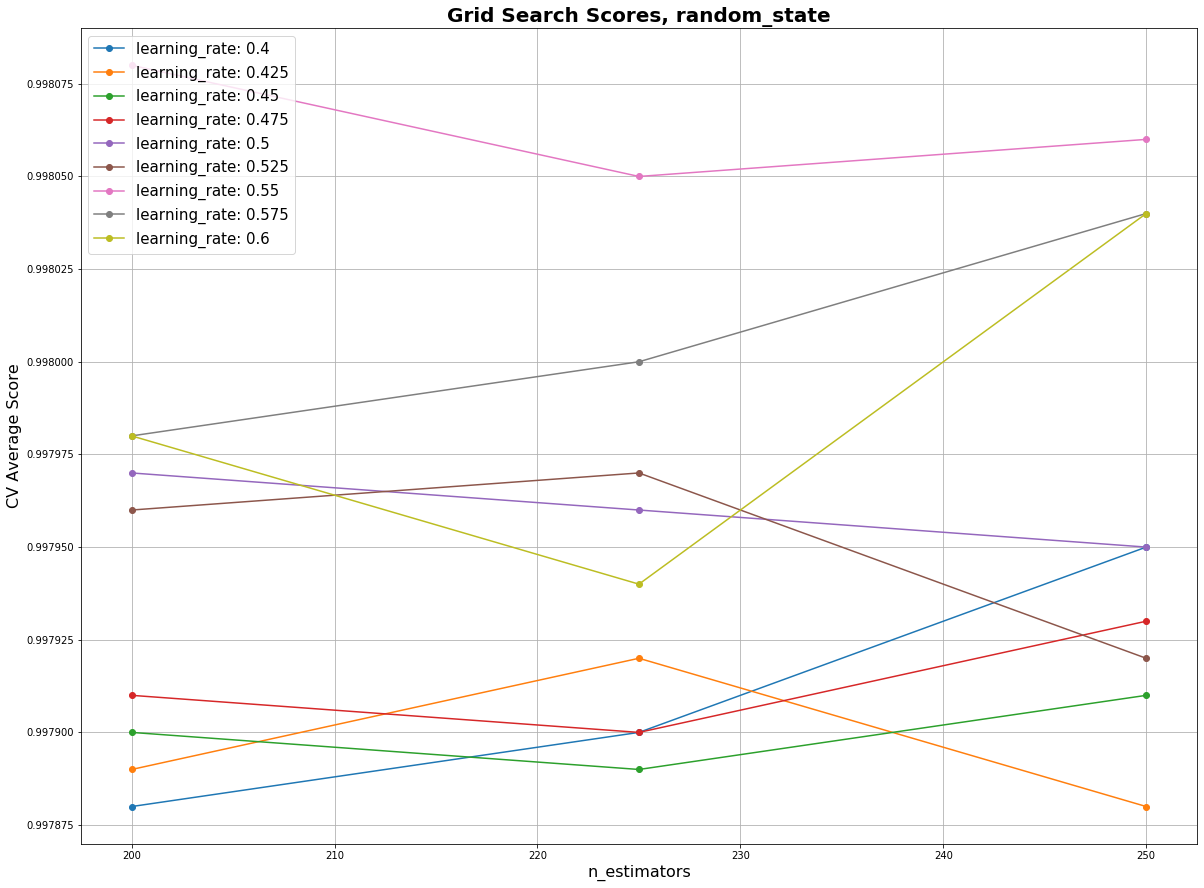

In [15]:
best_estimator_ada=grid_ada3.best_params_['n_estimators']
best_lr=grid_ada3.best_params_['learning_rate']
plot_grid_search(grid_ada3.cv_results_,  p_grid_ada3['n_estimators'],p_grid_ada3['learning_rate'], 'n_estimators','learning_rate')

In [16]:
ada1=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada1.fit(x_train,y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",ada1.score(x_train,y_train))
print("Test score :",ada1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99864
Test score : 0.99799


In [17]:
ada2=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada2.fit(x_train_scale,y_train)
print("Imbalanced Dataset scaled")
print("Training score :",ada2.score(x_train_scale,y_train))
print("Test score :",ada2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99864
Test score : 0.99799


In [40]:
ada3=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada3.fit(x_sample1,y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",ada3.score(x_sample1,y_sample1))
print("Test score :",ada3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 0.9976815806775321
Test score : 0.99639


In [41]:
ada4=AdaBoostClassifier(n_estimators=best_estimator_ada, learning_rate=best_lr)
ada4.fit(x_sample2,y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",ada4.score(x_sample2,y_sample2))
print("Test score :",ada4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.9985466625142738
Test score : 0.99682


##### Submit a result

In [42]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf=AdaBoostClassifier(n_estimators=200, learning_rate=0.55)
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaBoost3.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.996956269121

Once agin we notice that looking too precisely for the best hyperparameters doesn't always get better results. Indeed, there is randomness in cross validation used in GridSearchCV.

## AdaBoost on Random Forest

In order to limit the computationnal time, I have chosen to fix the number of estimators in Random Forest at 20. 
We have seen in the previous models that Random Forest doesn't improve a lot when the number of estimators increase. 

We also choose to limit ourselves to small depths without carrying out tests, we indeed noticed in the previous models that small depths were better. 

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

depth=[2,4,6,8]
p_grid_Ada_RF = {'n_estimators': [100,150,200],'learning_rate':[0.9,0.95,0.98],}
score_ada_rf=[]
parameters_ada_rf=[]
for i in depth:
    model = AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=i, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
    grid_ada_RF = GridSearchCV(estimator=model, param_grid=p_grid_Ada_RF, scoring="accuracy", cv=5)
    grid_ada_RF.fit(x_train_scale, y_train)
    score_ada_rf.append(grid_ada_RF.best_score_)
    parameters_ada_rf.append(grid_ada_RF.best_params_)
    

Text(0.5, 1.0, 'Best GridSearch Score according to max_depth')

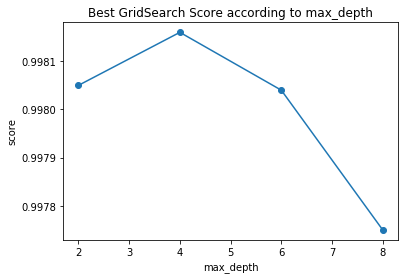

In [14]:
depth=[2,4,6,8]
best_estimator_RF=20
idx=score_ada_rf.index(max(score_ada_rf))
best_depth=depth[idx]
estimators_=[dic['n_estimators'] for dic in parameters_ada_rf]
lr_=[dic['learning_rate'] for dic in parameters_ada_rf]
best_estimator_=estimators_[idx]
best_lr_=lr_[idx]

plt.figure()
plt.plot(depth,score_ada_rf,marker='o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Best GridSearch Score according to max_depth')

The best max_depth is 4. We decide to work with this depth for the end of the notebook.

Text(0.5, 1.0, 'Best GridSearch nb_estimator according to max_depth')

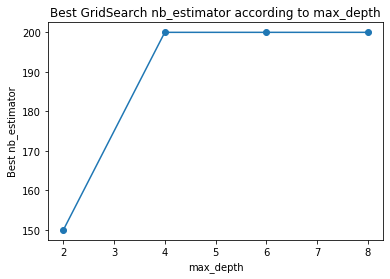

In [9]:
plt.figure()
plt.plot(depth,estimators_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best nb_estimator')
plt.title('Best GridSearch nb_estimator according to max_depth')

It seems that deeper trees need more estimators in adaBoost to get good results.

Text(0.5, 1.0, 'Best GridSearch learning rate according to max_depth')

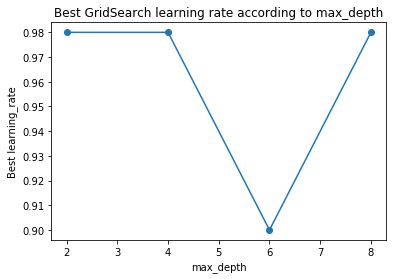

In [10]:
plt.figure()
plt.plot(depth,lr_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best learning_rate')
plt.title('Best GridSearch learning rate according to max_depth')

Let's test this first model :

In [25]:
clf1= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99839


In [26]:
clf2= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99836


In [27]:
clf3= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99729


In [28]:
clf4= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99778


Once again, we note that balanced data perform worse than unbalanced data.  SMOTE performs even worse than OverSampling. Indeed, the SMOTE algorithm generates noise to which AdaBoost is particularly sensitive. 


So we decided to test lower learnings_rate. We also decided to test the entropy criterion of the random forest.
We fixed max_depth = 4 because the computationnak time for this research is very long, and we've already seen that a simple weak classifier prevents over-fitting.

#### Submit a result

In [40]:
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
clf2= AdaBoostClassifier(RandomForestClassifier(criterion="gini",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=200,learning_rate=0.98,algorithm="SAMME")
clf.fit(X_,Y)
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_challenge_student_ada_RF1.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998459450272

I decided to use the criterion entropy given the previous results on RandomForest and on AdaBoost on DecisionTreeClassifier.

### Entropy criterion

In [16]:
p_grid_Ada_RF2 = {'n_estimators': [100,150,200,250],'learning_rate':[0.3,0.5,0.7,0.9]}

model = AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_RF2 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_RF2, scoring="accuracy", cv=5)
grid_ada_RF2.fit(x_train_scale, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=RandomForestClassifier(bootstrap=True,
                                                                                ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                max_samples=None,
                                                                                min_impurity_decrease=0.0,
            

In [17]:
print("Best Score: {}".format(grid_ada_RF2.best_score_))
print("Best params: {}".format(grid_ada_RF2.best_params_))
best_estimator_=grid_ada_RF2.best_params_['n_estimators']
best_lr_adaTree=grid_ada_RF2.best_params_['learning_rate']
best_depth=4

Best Score: 0.9983700000000001
Best params: {'learning_rate': 0.5, 'n_estimators': 200}


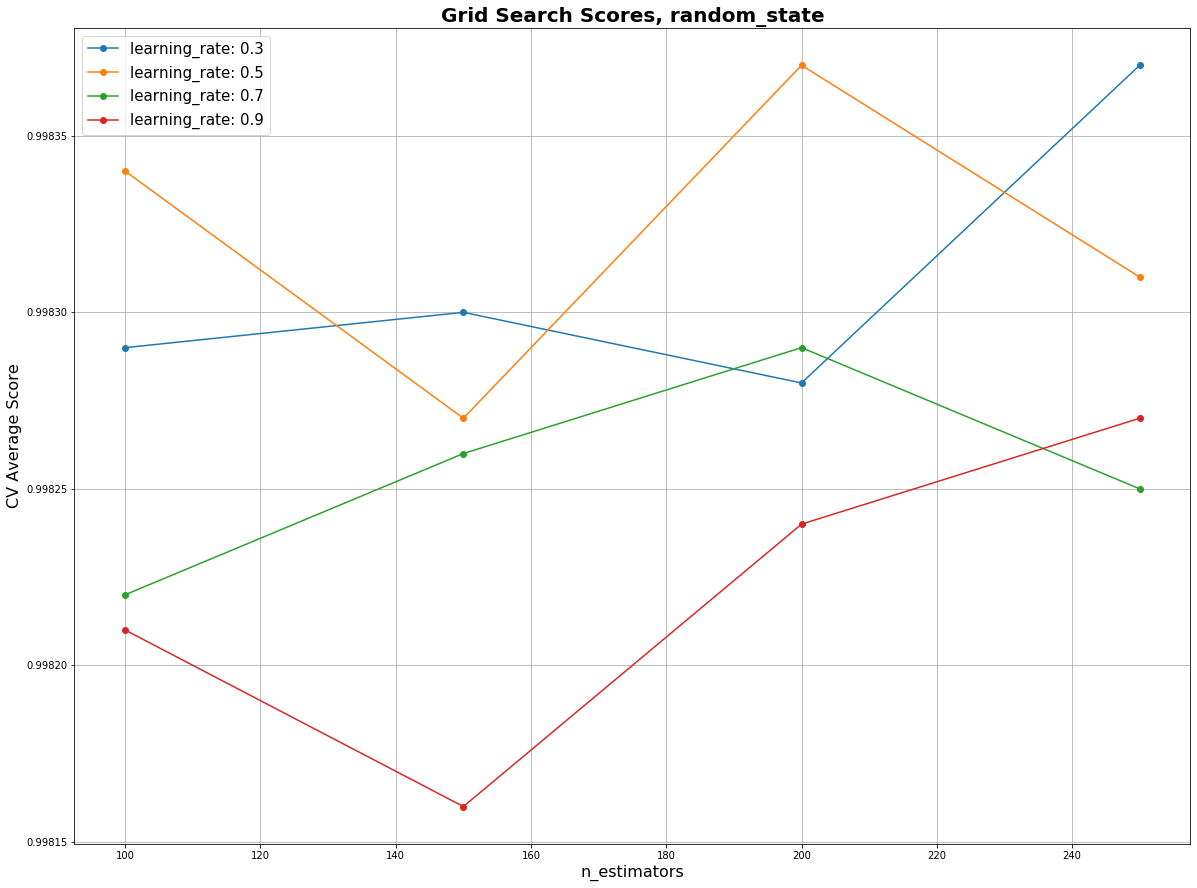

In [19]:
plot_grid_search(grid_ada_RF2.cv_results_,  p_grid_Ada_RF2['n_estimators'],p_grid_Ada_RF2['learning_rate'], 'n_estimators','learning_rate')

In [20]:
clf1= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99846


In [21]:
clf2= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99838


In [22]:
clf3= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.9974


In [23]:
clf4= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99762


#### Submit a result

In [41]:
clf= AdaBoostClassifier(RandomForestClassifier(criterion="entropy",n_estimators=20,max_depth=4, max_features='sqrt'),
                        n_estimators=200,learning_rate=0.5,algorithm="SAMME")
clf.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_challenge_adaRF.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998449204049

## Area for improvement : 

First of all, we could look for the best hyperparameters with more details. 

Then we could use a large number of estimator in randomForest. Using randomForest with more estimators gives very good results as shown in the tests below. However, I'm limited by the computational capabilities of my computer, and training a single model takes about a day. Indeed it is necessary to generate nb_estimators_RanfomForest x nb_estimators_AdaBoost decision trees for each training.

In [ ]:
clf2=AdaBoostClassifier(RandomForestClassifier(max_depth=4,criterion="gini",class_weight={0:1,1:1},max_features='sqrt',n_estimators=50),n_estimators=225,learning_rate=0.55,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree-50-225-0.55.csv', ytest, fmt = '%1.0d', delimiter=',')

Score : 0.998517914014




I noticed that if we decide to use a large number of estimators for Random Forest, it is better to use a small learning rate :

In [ ]:
clf2=AdaBoostClassifier(RandomForestClassifier(max_depth=4,criterion="entropy",class_weight={0:1,1:1},max_features='sqrt',n_estimators=75),n_estimators=225,learning_rate=0.825,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree-75-225-0825.csv', ytest, fmt = '%1.0d', delimiter=',')

Score : 0.998426903447

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf2=AdaBoostClassifier(RandomForestClassifier(criterion="entropy", max_depth=4, max_features='sqrt',n_estimators=75),
                               n_estimators=225,learning_rate=1,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree_75_225_1.csv', ytest, fmt = '%1.0d', delimiter=',')

Score : 0.99844257414